In [1]:
import sys
sys.path.insert(0, '../../')

import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import hyperspy.api as hs

from tqdm import tqdm

from temnn.data.mods import local_normalize

from scipy import ndimage

In [2]:
dataset = 'Au_fcc_newmtf'

In [3]:
# Open Parameters file
fn = '../simulation_data/' + dataset
vdatf = fn + '-test'
with open(os.path.join(vdatf, 'parameters.json')) as json_file:
    vpar = json.load(json_file)
vflsin = os.path.join(vdatf, 'images_labels')

In [4]:
# Read number of validation images
vimgs_e = vpar['images_per_epoch']
imgdim = tuple(vpar['image_size']) # spatial dimensions of input/output
if vpar.get('multifocus', None):
    chan_in = vpar['multifocus'][0]
else:
    chan_in = 1 # depth of input data
chan_out = vpar['num_classes'] # number of predicted class labels

vinp = np.empty((vimgs_e,imgdim[0],imgdim[1],chan_in),
                                        np.float32)
vtar = np.empty((vimgs_e,imgdim[0],imgdim[1],chan_out),
                                        np.float32)
for i in tqdm(range(vimgs_e),desc='Loading images'):
    d = np.load(os.path.join(vflsin,
                'image_label_{:03d}_{:04d}.npz'.format(0, i)))
    try:
        vinp[i] = d['image'].astype(np.float32)
        vtar[i] = d['label'].astype(np.int8)
    except ValueError:
        vinp[i] = d['image'][:,:imgdim[0],:imgdim[1],:].astype(np.float32)
        vtar[i] = d['label'][:,:imgdim[0],:imgdim[1],:].astype(np.int8)

Loading images: 100%|██████████| 100/100 [00:02<00:00, 35.71it/s]


In [5]:
idx = 22
sim = np.expand_dims(vinp[idx],axis=0)

In [6]:
def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    #cf = f.shape[0]/2,f.shape[1]/2
    #f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.abs(f) #np.log(np.abs(f)) #np.log(1+np.abs(f))

In [7]:
folder='../experimental_data/WilliamBang/20201201_ETEM_MEMS6/ROI1'
doserate='DR1_AuNP1_ADC'
files=glob.glob(r'{}/{}/Hour_00/Minute_*/Second_*/*.dm4'.format(folder,doserate))

In [8]:
if not os.path.exists('stack_{}.hspy'.format(doserate)):
    exp_hs=hs.load(files,lazy=True,stack=True)
    # Saving the whole stack as a hyperspy object in this new output folder (you could do this as a tif or hdf5)
    # This is smaller than the combination of all the dm4 files
    exp_hs.save('stack_{}.hspy'.format(doserate),overwrite=True)
# Now I can load the hyperspy file rather than use the lazy-loaded individual files
exp_hs=hs.load('stack_{}.hspy'.format(doserate),lazy=False)
# This is because we loaded the data as a stack. The stack metadata has each individual frame's metadata
# The original data is in a 'DictionaryTree' but we want to loop through it
# So I am converting it to a standard Python dictionary
stack_metadata=exp_hs.original_metadata.stack_elements.as_dictionary()

# An individual frame's metadata is then:
frame_index=0
frame_metadata=stack_metadata['element{}'.format(frame_index)]

exp_hs.axes_manager.navigation_axes[0].scale=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']
exp_hs.axes_manager.navigation_axes[0].units='s'
exp_hs.axes_manager.navigation_axes[0].name='t'
exp_hs.axes_manager

normalizerange = 12.0/((exp_hs.axes_manager.signal_axes[0].scale)*10)
exp = local_normalize(exp_hs.data[frame_index], normalizerange, normalizerange)

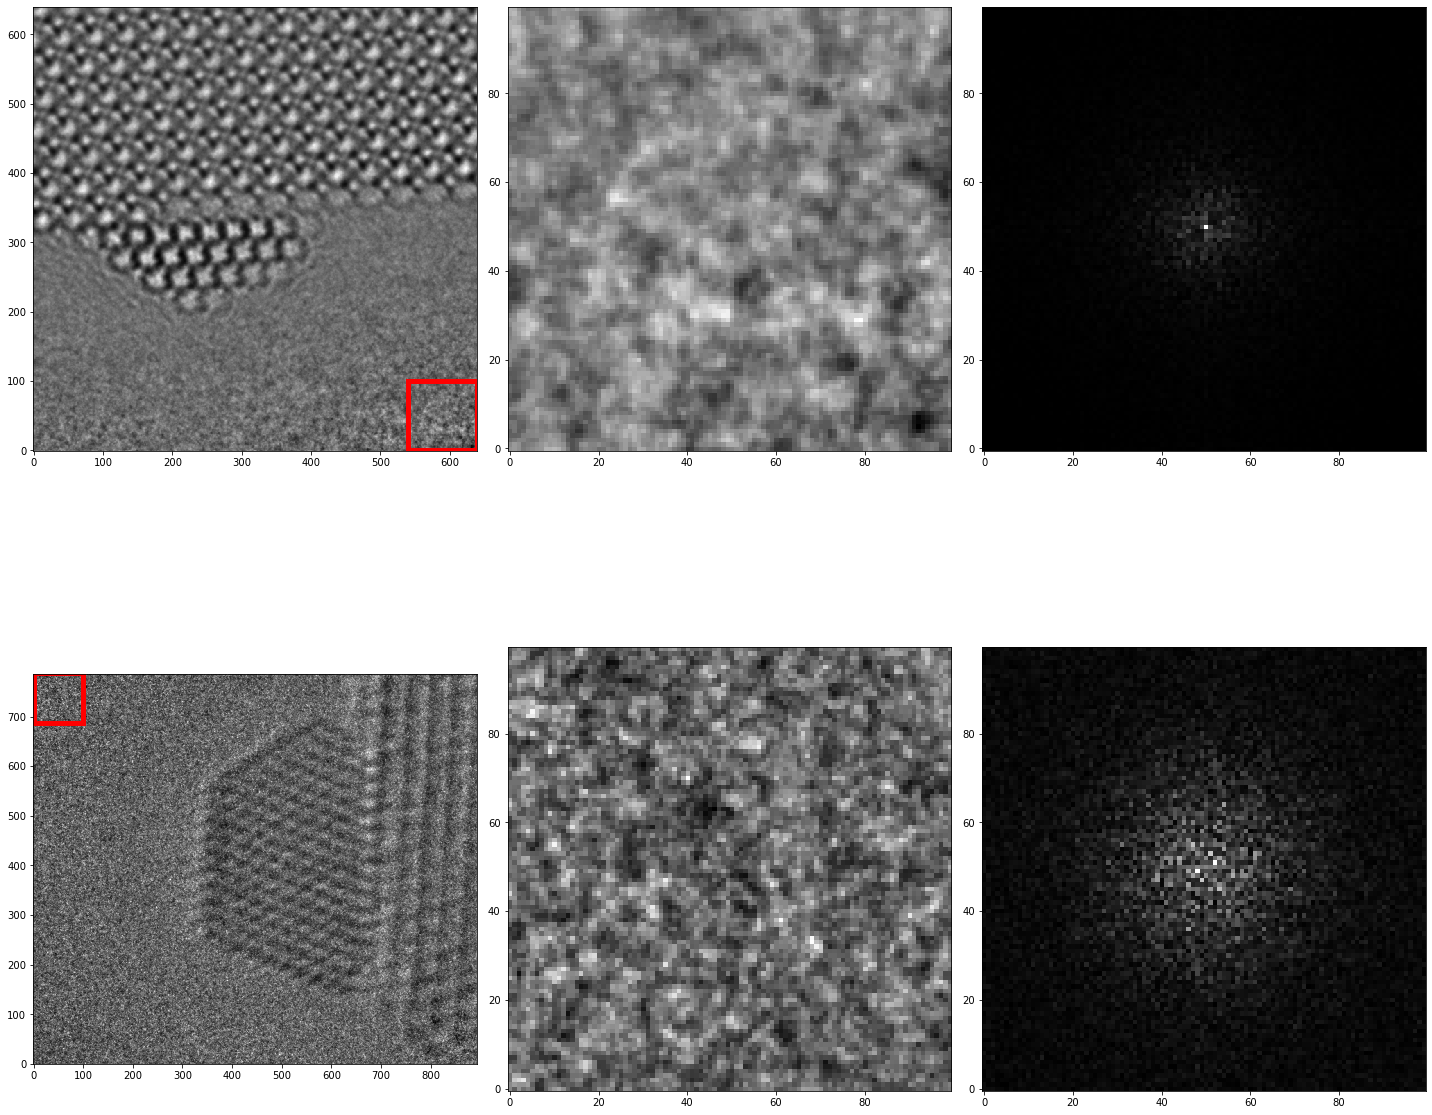

In [9]:
size = 100
fig, axs = plt.subplots(2,3, figsize=(20,20))

axs[0,0].imshow(sim[0,:,:,0],origin='lower',cmap='gray',interpolation='nearest')

sim_roi = (sim.shape[1]-size, 0)
#sim_roi = (sim.shape[2]-size, sim.shape[2]-size)
# Create a Rectangle patch
rect = patches.Rectangle(sim_roi, size, size, linewidth=5, edgecolor='r', facecolor='none')
# Add the patch to the Axes
axs[0,0].add_patch(rect)

roi = sim[ 0, sim_roi[1]:sim_roi[1]+size, sim_roi[0]:sim_roi[0]+size, 0 ]
sim_psd2d = fft(roi)
axs[0,1].imshow(roi,origin='lower',cmap='gray',interpolation='nearest')
axs[0,2].imshow(sim_psd2d,origin='lower',cmap='gray',interpolation='nearest')

axs[1,0].imshow(exp,origin='lower',cmap='gray',interpolation='nearest')

exp_roi = (0,exp.shape[0]-size)
# Create a Rectangle patch
rect2 = patches.Rectangle(exp_roi, size, size, linewidth=5, edgecolor='r', facecolor='none')
# Add the patch to the Axes
axs[1,0].add_patch(rect2)

roi = exp[ exp_roi[1]:exp_roi[1]+size, exp_roi[0]:exp_roi[0]+size ]
exp_psd2d = fft(roi)
axs[1,1].imshow(roi,origin='lower',cmap='gray',interpolation='nearest')
axs[1,2].imshow(exp_psd2d,origin='lower',cmap='gray',interpolation='nearest')
plt.tight_layout()
plt.show()

In [10]:
# Open Parameters file
fn = '../simulation_data/' + dataset
tem_paraf = fn + '-test' + '/tem_params'
with open(os.path.join(tem_paraf, 'parameters_{:03d}_{:04d}'.format(0, idx))) as json_file:
    tem_para = json.load(json_file)
tem_para

{'blur': 0.619503099755103,
 'ctf_c12': 16.795263815018135,
 'ctf_c21': 36.11113963012713,
 'ctf_c23': 433.42295208216797,
 'ctf_c30': 70073.86093758607,
 'ctf_c32': 5200.28836899205,
 'ctf_c34': 87283.13101268158,
 'ctf_c45': 5410379.793496765,
 'ctf_phi12': 3.0249206021810267,
 'ctf_phi21': 6.222728607602612,
 'ctf_phi23': 1.6289340861509025,
 'ctf_phi32': 3.4283279477595427,
 'ctf_phi34': 2.3442334051291973,
 'ctf_phi45': 4.112184634792637,
 'defocus': 122.8789413589102,
 'dose': 1240.8203382158963,
 'focal_spread': 16.11046416088707,
 'mtf_c0': 1.0,
 'mtf_c1': 0.08257247445919175,
 'mtf_c2': 0.5479726707459159,
 'mtf_c3': 2.2925891023960583,
 'sampling': 0.07215499389239209}

In [11]:
#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    #psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))
    
    return psd1D, r
#===================================================================

#=============================================================================
# Get PSD 1D (total power spectrum by angular bin)
#=============================================================================
def GetRPSD(psd2D, dTheta, rMin, rMax):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2
    
    # note that displaying PSD as image inverts Y axis
    # create an array of integer angular slices of dTheta
    Y, X  = np.ogrid[0:h, 0:w]
    theta = np.rad2deg(np.arctan2(-(Y-hc), (X-wc)))
    theta = np.mod(theta + dTheta/2 + 360, 360)
    theta = dTheta * (theta//dTheta)
    theta = theta.astype(np.int)
    
    # mask below rMin and above rMax by setting to -100
    R     = np.hypot(-(Y-hc), (X-wc))
    mask  = np.logical_and(R > rMin, R < rMax)
    theta = theta + 100
    theta = np.multiply(mask, theta)
    theta = theta - 100
    
    # SUM all psd2D pixels with label 'theta' for 0<=theta❤60 between rMin and rMax
    angF  = np.arange(0, 360, int(dTheta))
    #psd1D = ndimage.sum(psd2D, theta, index=angF)
    psd1D = ndimage.mean(psd2D, theta, index=angF)
    
    # normalize each sector to the total sector power
    pwrTotal = np.sum(psd1D)
    psd1D    = psd1D/pwrTotal
    
    return angF, psd1D, theta
#=============================================================================

In [12]:
sim_psd1d, sim_azmask = GetPSD1D(sim_psd2d)
exp_psd1d, exp_azmask = GetPSD1D(exp_psd2d)

sim_angF, sim_rpsd1d, sim_rmask = GetRPSD(sim_psd2d,dTheta=30,rMin=0,rMax=50)
exp_angF, exp_rpsd1d, exp_rmask = GetRPSD(exp_psd2d,dTheta=30,rMin=0,rMax=50)

In [13]:
def default_mtf_func(k: np.ndarray, c0: float, c1: float, c2: float, c3: float):
    return (c0 - c1) / (1 + (k / (2 * c2))**np.abs(c3)) + c1

mtf_params = {'c0': tem_para['mtf_c0'],
             'c1': tem_para['mtf_c1'],
             'c2': tem_para['mtf_c2'],
             'c3': tem_para['mtf_c0']
             }

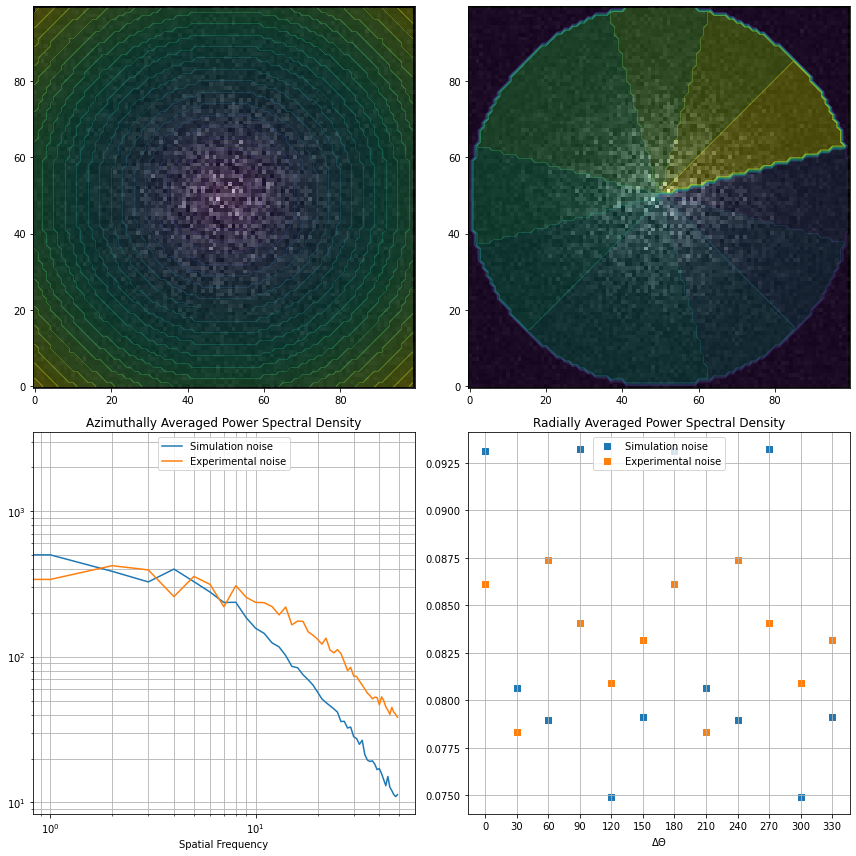

In [14]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

q = np.linspace(0,len(sim_psd1d))
mtf_q = default_mtf_func(q, **mtf_params)

axs[0,0].contourf(sim_azmask,alpha=0.3,levels=int(len(exp_psd1d)/2))
axs[0,0].imshow(exp_psd2d,origin='lower',cmap='gray',interpolation='nearest')

axs[1,0].loglog(sim_psd1d)
axs[1,0].loglog(exp_psd1d)
# axs[1,0].loglog(mtf_q*100)
axs[1,0].legend(['Simulation noise', 'Experimental noise'],loc='upper center')
axs[1,0].grid(True, which="both", ls="-")
axs[1,0].set_xlabel("Spatial Frequency")
axs[1,0].set_title("Azimuthally Averaged Power Spectral Density")

axs[0,1].contourf(sim_rmask,alpha=0.3,levels=len(exp_angF))
axs[0,1].imshow(exp_psd2d,origin='lower',cmap='gray',interpolation='nearest')

axs[1,1].scatter(sim_angF,sim_rpsd1d,marker='s')
axs[1,1].scatter(exp_angF,exp_rpsd1d,marker='s')
axs[1,1].set_xticks(sim_angF)
axs[1,1].legend(['Simulation noise', 'Experimental noise'],loc='upper center')
axs[1,1].grid(True, which='major')
axs[1,1].set_xlabel(r"$\Delta \Theta$")
axs[1,1].set_title("Radially Averaged Power Spectral Density")

plt.tight_layout()
plt.show()

In [15]:
print('Simulated sectors variance: {}, Experimental sectors variance: {}'.format(np.var(sim_rpsd1d),np.var(exp_rpsd1d)))
print('Simulated anisotropy metric: {}, Experimental anisotropy metric: {}'.format(2*(np.max(sim_rpsd1d)-np.min(sim_rpsd1d)),2*(np.max(exp_rpsd1d)-np.min(exp_rpsd1d))))

Simulated sectors variance: 5.1358105965364e-05, Experimental sectors variance: 9.313341416480149e-06
Simulated anisotropy metric: 0.036542894929769754, Experimental anisotropy metric: 0.01814073190705487


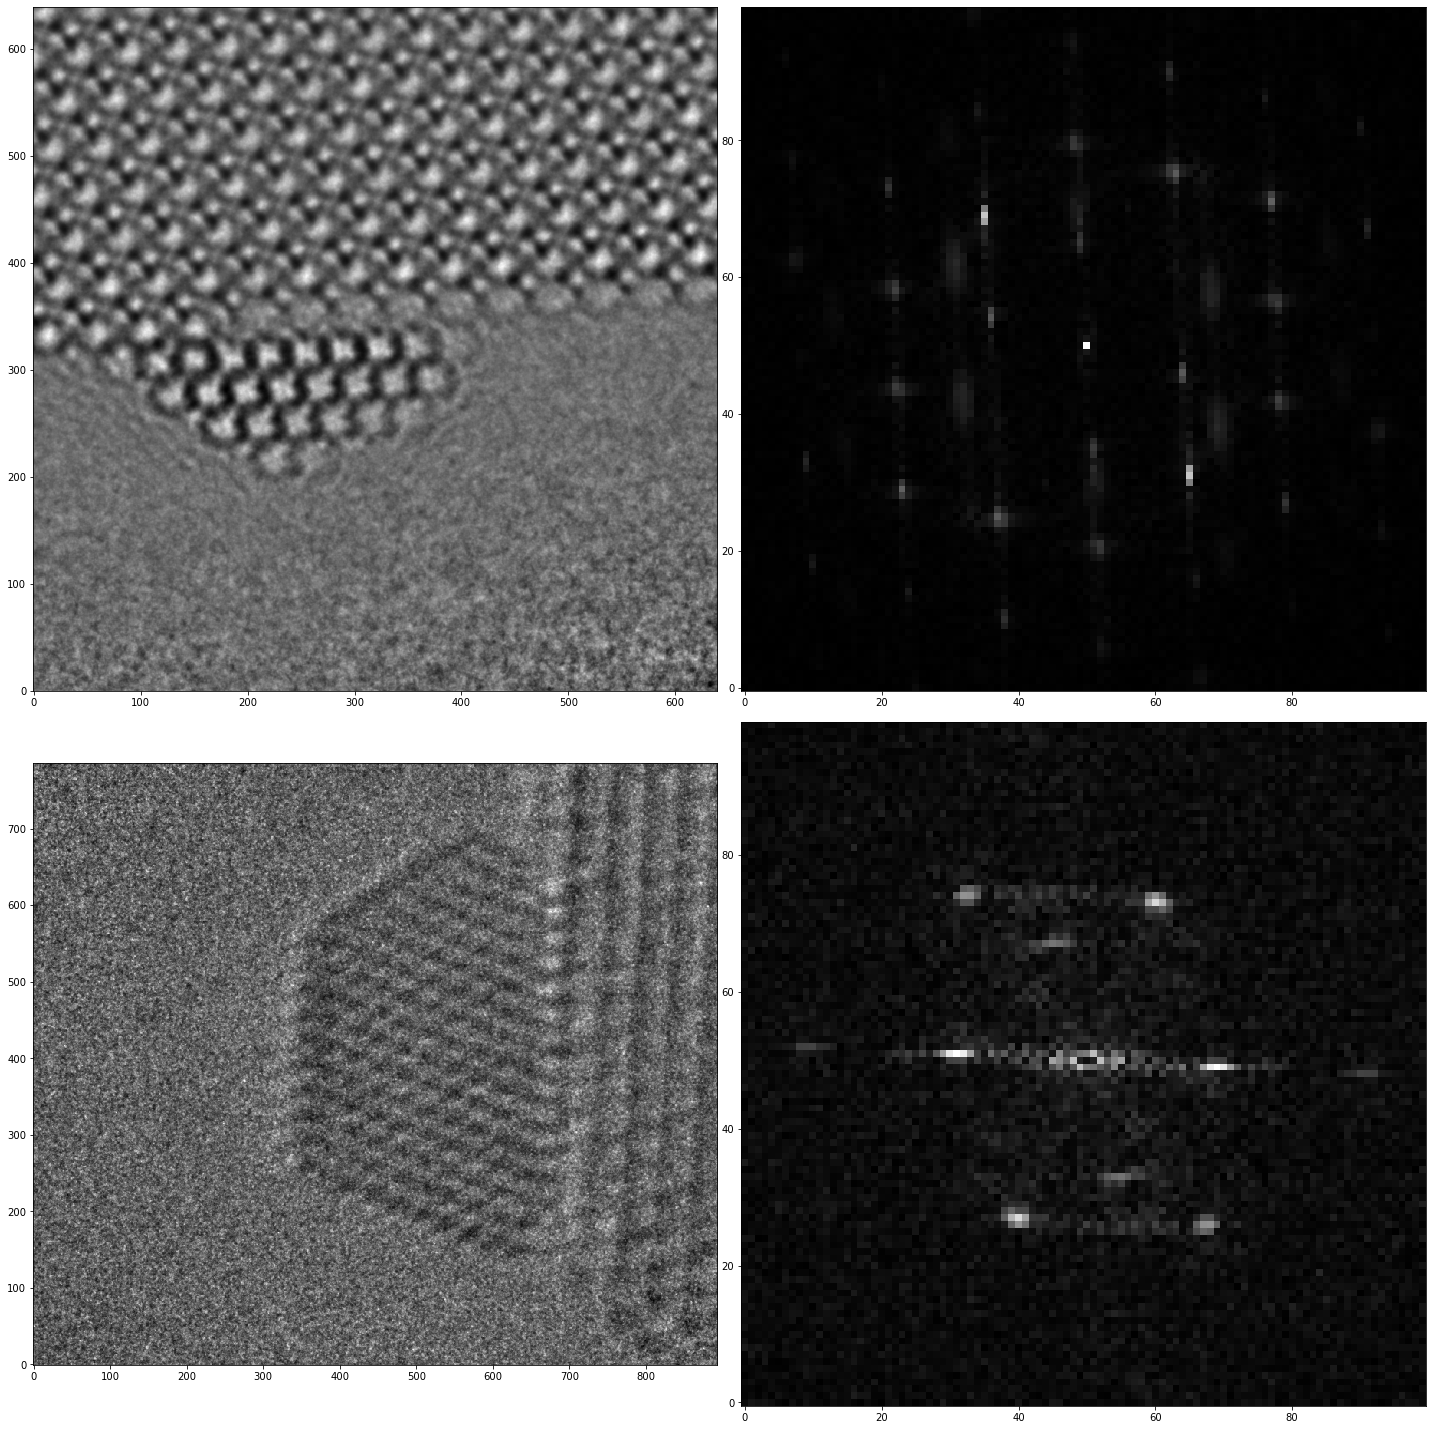

In [16]:
sim_fft = fft(sim[0,:,:,0])
exp_fft = fft(exp)

sim_center = sim_fft.shape[0]/2,sim_fft.shape[1]/2
sim_fft_crop = sim_fft[int(sim_center[0]-50):int(sim_center[0]+50),int(sim_center[1]-50):int(sim_center[1]+50)]

exp_center = exp_fft.shape[0]/2,exp_fft.shape[1]/2
exp_fft_crop = exp_fft[int(exp_center[0]-50):int(exp_center[0]+50),int(exp_center[1]-50):int(exp_center[1]+50)]

fig, axs = plt.subplots(2,2, figsize=(20,20))

axs[0,0].imshow(sim[0,:,:,0],origin='lower',cmap='gray',interpolation='nearest')
axs[0,1].imshow(sim_fft_crop,origin='lower',cmap='gray',interpolation='nearest')

axs[1,0].imshow(exp,origin='lower',cmap='gray',interpolation='nearest')
axs[1,1].imshow(exp_fft_crop,origin='lower',cmap='gray',interpolation='nearest')

plt.tight_layout()
plt.show()